# Recovery Algorithms -- Part I: OMP

In this notebook, we examine some CS algorithms, we learned in the lecture. These algorithms have been implemented in the module 'CS_recovery_algorithms.py'. If you have saved it in another directory make sure to reset the directory path correspondingly. We are going to work with <numpy.ndarray>. So, we import both the modules.

In [2]:
import numpy as np
import CS_recovery_algorithms as cs

## Orthogonal Matching Pursuit (OMP)
OMP has been implemented as OMP in the module. We first try it for the example in the assignment which can be easily solved by hand.

In [3]:
# Sampling Matrix A
A = np.array([
    [1, 1, 1, 0],
    [1, 0, -1, 0],
    [0, .5, 0, 1]
])

# Samples y
y  = np.array([
    [1, 1 , 3]
]).T

# Sparsity factor s = sparsity/signal_dimension = 2/4 = 0.5
s = .5

# Recovery by OMP
x = cs.OMP(A, y, s)
print(x)

[[1.]
 [0.]
 [0.]
 [3.]]


Well! It looks fine. We could further double-check:

In [4]:
np.linalg.norm(y - np.dot(A,x), ord = 2)

4.710277376051326e-16

OK! That's it! Now let us do try understand the performance of OMP.

### Performance of OMP
The performance characterization can be addressed via this classic approach. We can generate a random signal of a large dimension with fixed sparsity. We then start from a certain number of samples and increase it step by step. At each step, we generate a random sampling matrix and calculate the probability of recovering our signal. We then plot this probability against the number of samples. Intuitively, we need to always improve and at some point jump from low chances to somewhere close to 1. Where does this happen? This is actually what would characterize out algorithm. Let's now try it for OMP.

In the following, we write the function "Success_Prob(alg, delta, s)" which detemines the success rate for the given algorithm "alg" considering the compression rate "delta = M/N" and the sparsity factor "s = sparsity/N". 

In [5]:
## This function calculates the success probability
### It averages over 1000 random realizations
### Signal dimension is set to 100
def Success_Prob(alg, delta, s):
    '''
    alg: function, a CS recovery algorithm
    delta = M/N with M being the number of samples and N being the signal dimension
    s = sparsity factor, s = sparsity/N
    '''

    # We set the signal dimension to 100
    N = 100
    
    # The number of samples is calculated from the definition delta = M/N
    M = int(delta * N)
    
    # Let's set the number of realizations to 1000
    ITR = 1000
    
    # Let's calculate the average performance
    ## We have not yet had any successful recovery
    flag = 0 # number of successful recoveries
    
    for _ in range(ITR):
        # First we generate a random signal with sparsity factor s
        x_0 = (np.random.uniform(0, 1, (N,1)) <= s ) * np.random.randn(N,1)
        
        # Now, we generate a random sampling matrix
        A = np.random.randn(M, N)
        
        # Then, we sample x with A
        y = np.dot(A,x_0)
        
        # And recover x from y and A
        x_hat = alg(A, y, s)
        
        # Now we check whether we were successful
        dif = np.linalg.norm(x_hat - x_0 , ord = 2)
        if dif <= 1e-7:
            flag +=1
        
        
    # P_Success is hence
    P_s = flag/ITR
    
    return P_s

We now try it for a range of $\delta \in [0,1]$ and setting $s = 0.1$

In [6]:
# Sparsity factor 
s = 0.1 # 10% sparse

# Step-size of changing delta
step_delta = 0.025
delta_vec = np.arange(.05, 1.05 + step_delta, step_delta)

# Initial Probabilities
Prob = []

for delta in delta_vec:
    # You could also track delta, if you wish
    # print(f'delta = {delta}')
    P_delta  = Success_Prob(cs.OMP, (delta), s)
    Prob.append( float(P_delta) )


OK! Now we can plot the Probability of success against $\delta = M/N$

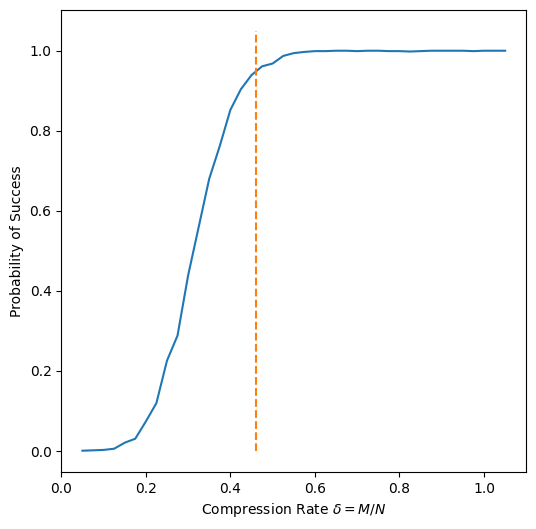

In [7]:
import matplotlib.pyplot as plt

# Plot Success Probability against delta
plt.figure(figsize = (6,6))
plt.plot(delta_vec, Prob)
plt.ylabel('Probability of Success')
plt.xlabel('Compression Rate $\delta = M/N$')

# Determine the bound for random iid matrices
delta_min = - 2 * s * np.log(s)
plt.plot([delta_min, delta_min], [0, 1.05], '--')


The blue curve shows the performance of OMP. It seems fine, since it increases against $\delta$: More samples lead to better recovery. The orange line further shows the minimum number of samples we require to have the RIP constraint satisfied via random i.i.d Matrices. As it shows, when we pass this limit, the recovery algorithm performs close to perfect. Remember that all out bounds are derived in the asymptotic case. Thus, with finite-dimensional simulations, we should accept some levels of imperfection.

## Exercise
Use i.i.d. Gaussian matrices to sample the MRI images we used in the first notebook. Try to first transfer the image to the Fourier domain, and then sample it. Try to recover it via OMP (first recover in the Fourier domain, then transfer it back to the spatial domain). Compare what you recover for two different settings: (1) Number of samples being below the minimum number of required samples for RIP guarantee. (2) Number of samples being below this limit. Check, if you see what you expected.